In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy.matlib
import numpy as np
from numpy import median

import scipy.stats as stats
import scipy.special

import re
import sys

from IPython.display import (
    display_pretty, display_html, display_jpeg,
    display_png, display_json, display_latex, display_svg
)

from IPython.display import display
import itertools
import gc

import statsmodels.api as sm
import statsmodels.stats.multitest as smm
import statsmodels.formula.api as smf

big = pd.read_csv('TAG Data.csv')

## Drop "Feature" and "Confidence Level" columns

In [3]:
df = pd.read_csv("Mega Large Merge.csv")

df = df.drop(columns = {"Feature", "Confidence Level", "IB"})

C:\Users\jazzy\Anaconda2\lib\site-packages\IPython\core\interactiveshell.py:2714: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Logged Based plotting

AxesSubplot(0.125,0.125;0.775x0.755)


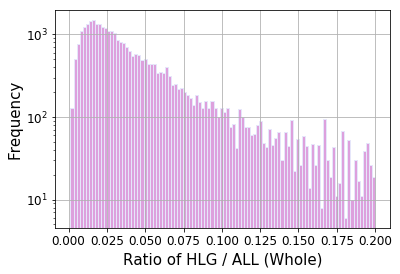

In [4]:
big = big[['IB' , 'gene' , 'R5-S#11-HLG_WHOLE_normalized_reads' , 'R5-S#11-ALL_WHOLE_normalized_reads']]
big ['Ratios: HLG / ALL (Whole)'] = big ['R5-S#11-HLG_WHOLE_normalized_reads'] / big['R5-S#11-ALL_WHOLE_normalized_reads']

# ~ 0 for not enriched
filter = big['Ratios: HLG / ALL (Whole)'] > 0
filter1 = big ['Ratios: HLG / ALL (Whole)'] <= 0.2
big.where(filter & filter1, inplace = True)

big = big.dropna()

histo = big['Ratios: HLG / ALL (Whole)'].hist(bins = 100, color = 'plum', edgecolor = 'lavender', grid = True, xlabelsize = 12, ylabelsize = 12, log = True)
plt.xlabel("Ratio of HLG / ALL (Whole)", fontsize = 15)
plt.ylabel("Frequency", fontsize = 15)

print histo

## Number of rows with a ratio between 0 and 0.2

In [6]:
big['gene'].count()

31329

## Number of unique values in the 'gene' column with a ration between 0 and 0.2

In [8]:
big['gene'].nunique()

11504

## Time to go Fishing

In [5]:
matrix = df.to_numpy()

oarfish = pd.DataFrame(matrix, columns = ["Gene", "Ratio Median",
                                          "Ratio Mean", "GO Term",
                                          "Description"])

oarfish = oarfish.drop_duplicates()

## Type of Ratio

In [6]:
data = pd.read_csv('TAG Data.csv')

data = data[['IB' , 'gene' , 'R5-S#11-HLG_WHOLE_normalized_reads' , 'R5-S#11-ALL_WHOLE_normalized_reads']]
data ['Ratios: HLG / ALL (Whole)'] = data ['R5-S#11-HLG_WHOLE_normalized_reads'] / data['R5-S#11-ALL_WHOLE_normalized_reads']

data = data.sort_values('gene')
data = data.replace([np.inf, -np.inf], np.nan)
data = data.dropna()
data = data.drop(columns = {"R5-S#11-HLG_WHOLE_normalized_reads", 
                            "R5-S#11-ALL_WHOLE_normalized_reads"})

data["RatioType"] = np.where(data["Ratios: HLG / ALL (Whole)"] > 1, 
                                 "Hit", "Non-Hit")
data = data.sort_values("gene")
data = data.reset_index(drop = True)
data = data.replace(['unknown_chrom', 'no_gene_found', 
                     'gene_unknown'], np.nan)
data = data.dropna()

## For unknown genes

In [7]:
unknown = data[data.gene.eq("unknown_chrom") |
               data.gene.eq("no_gene_found") |
               data.gene.eq("gene_unknown")]

unknown = unknown.reset_index(drop = True)

## Iterate through entire dataframe to make dataframes for each unique gene

In [14]:
for gene, data_gene in data.groupby('gene'):
    data_gene

## Prepping to go Fishing

In [8]:
bigHit = 0
bigNo = 0

for gene, data_genie in data.groupby('gene'):
    data_genie = data_genie.drop(columns = {'IB', "Ratios: HLG / ALL (Whole)"})
   
    hit = data_genie.loc[data_genie.RatioType == 'Hit', "RatioType"].count()
    noHit = data_genie.loc[data_genie.RatioType == "Non-Hit", "RatioType"].count()

    bigHit =  bigHit + hit
    bigNo = bigNo + noHit
    if "Cre52.g761647" in data_genie.values:
        sum = pd.DataFrame (
            { 
#                 'Gene': "  ",
                'Hit' : bigHit,
                'Non-Hit' : bigNo
#                 'Total': bigTotal
            }, index = [0]
        )

#         sum = sum.to_numpy()


## Actually time to go Fishing

In [9]:
for gene, data_genie in data.groupby('gene'):
    data_genie = data_genie.drop(columns = {'IB', "Ratios: HLG / ALL (Whole)"})
   
    hit = data_genie.loc[data_genie.RatioType == 'Hit', "RatioType"].count()
    noHit = data_genie.loc[data_genie.RatioType == "Non-Hit", "RatioType"].count()
#     total = hit + noHit
    
    bigHit =  bigHit + hit
    bigNo = bigNo + noHit
#     bigTotal = bigTotal + total
    
    genius = pd.DataFrame (

        {
        'Gene':data_genie.gene.unique()
        }
    )
    
    frame = pd.DataFrame ( 
         {
#             'Gene': data_genie.gene.unique(),
            'Hit' : hit,
            'Non-Hit' : noHit
#             'Total' : total
        }, index = [0]
    )


    concat = pd.concat([frame, sum], ignore_index = True)  
    concat = concat.to_numpy()
    
    obs = np.array(concat)
    fisher = stats.fisher_exact(obs)
    
    fishy = np.asarray(fisher)
    fishy = fishy.reshape(1,2)
    
    frame.astype(float)
    sum.astype(float)
    fsh = pd.DataFrame(data = fishy, columns = ["p-value", " 1.0"])
    fsh.astype(float)
    
    oarfish = np.concatenate((frame, sum), axis = 0)
    oarfish = pd.DataFrame(data = oarfish, columns = ["Hit", "Non-Hit"])

    anchovy = pd.DataFrame(data = fsh, columns = ["p-value"])

    bigFish = pd.concat([oarfish, anchovy], ignore_index = True, sort = True)
    bigFish = pd.concat([genius, bigFish], axis = 1)
    
#     bigFish = bigFish.replace(np.nan, '-')

    print(bigFish)

            Gene      Hit  Non-Hit   p-value
0  Cre01.g000017      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre01.g000033      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g000050      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre01.g000100      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g000150      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g000200      4.0      3.0      NaN
1            NaN  27479.

            Gene      Hit  Non-Hit  p-value
0  Cre01.g001750      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g001800      6.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre01.g001950      5.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.291962
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g001950 & Cre01.g001983      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g001983      6.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  N

            Gene      Hit  Non-Hit   p-value
0  Cre01.g003475      5.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre01.g003487      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre01.g003500      4.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g003500 & Cre01.g003508      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre01.g003508      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit   p-value
0  Cre01.g004950      5.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
            Gene      Hit  Non-Hit  p-value
0  Cre01.g005001      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g005050      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre01.g005100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g005150      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre01.g005200      3.0      5.0       NaN
1            NaN  2747

            Gene      Hit  Non-Hit   p-value
0  Cre01.g006950      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g006950 & Cre01.g007000      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g007000      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g007000 & Cre01.g007050      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g007100      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre01.g008891      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g008900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g008900 & Cre01.g008950      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre01.g008950      4.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.22238
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g008950 & Cre01.g008976      1.0      5.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre01.g010300 & Cre01.g010350      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g010350      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g010350 & Cre01.g010400      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g010400 & Cre01.g010450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g010450      0.0      2.0      NaN
1            NaN

            Gene      Hit  Non-Hit   p-value
0  Cre01.g012126      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit   p-value
0  Cre01.g012150      7.0     19.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.013289
            Gene      Hit  Non-Hit  p-value
0  Cre01.g012175      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g012200      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g012200 & Cre01.g012222      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  N

            Gene      Hit  Non-Hit   p-value
0  Cre01.g014100      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre01.g014150      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  Cre01.g014200      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g014250      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g014300      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit   p-value
0  Cre01.g014350      1.0      3.0       NaN
1            NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre01.g016100      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g016100 & Cre01.g016150      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre01.g016150      0.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g016200      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g016200 & Cre01.g016250      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

            Gene      Hit  Non-Hit   p-value
0  Cre01.g018000      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre01.g018050      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g018075      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre01.g018100      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre01.g018150      6.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre01.g018184      1.0      2.0       NaN
1            NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre01.g020100      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g020100 & Cre01.g020141      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g020141      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre01.g020182      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g020182 & Cre01.g020223      2.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre01.g022050      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre01.g022100      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g022100 & Cre01.g022150      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g022150      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g022150 & Cre01.g022200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre01.g023950      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g023950 & Cre01.g024000      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g024000      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g024000 & Cre01.g024050      3.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre01.g024050      5.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN     

            Gene      Hit  Non-Hit  p-value
0  Cre01.g025808      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g025808 & Cre01.g025850      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre01.g025850      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g025850 & Cre01.g025900      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre01.g025900      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre01.g027764      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre01.g027800      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g027850      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre01.g027900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g027950      4.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre01.g028000      1.0      5.0       NaN
1            NaN  2747

            Gene      Hit  Non-Hit  p-value
0  Cre01.g029800      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g029850      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre01.g029900      4.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g029900 & Cre01.g029950      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre01.g029950      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit  p-value
0  Cre01.g031650      0.0      8.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g031700      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre01.g031750      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre01.g031800      5.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre01.g031850      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g031850 & Cre01.g031875      0.0      5.0  

                            Gene      Hit  Non-Hit   p-value
0  Cre01.g033550 & Cre01.g033700      9.0     30.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit   p-value
0  Cre01.g033700      2.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.500065
            Gene      Hit  Non-Hit  p-value
0  Cre01.g033750      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g033763      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g033832      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre01.g035550      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre01.g035600      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre01.g035650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g035700      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre01.g035750      4.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.571631
            Gene      Hit  Non-Hit  p-value
0  Cre01.g035800      6.0      9.0      NaN
1            NaN  27

            Gene      Hit  Non-Hit  p-value
0  Cre01.g037900      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g037950      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre01.g038000      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g038000 & Cre01.g038050      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre01.g038050      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  N

            Gene      Hit  Non-Hit   p-value
0  Cre01.g039850      7.0     24.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.802187
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g039850 & Cre01.g039900      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre01.g039900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g039950      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre01.g040000      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit    p-value
0 

            Gene      Hit  Non-Hit  p-value
0  Cre01.g041650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g041650 & Cre01.g041667      4.0      7.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.571631
            Gene      Hit  Non-Hit  p-value
0  Cre01.g041667      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g041667 & Cre01.g041700      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre01.g041700      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre01.g043550      2.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.500065
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g043550 & Cre01.g043600      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre01.g043600      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre01.g043650      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre01.g043700      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre01.g045601      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre01.g045640      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre01.g045650      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  Cre01.g045700      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g045700 & Cre01.g045752      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-v

                            Gene      Hit  Non-Hit   p-value
0  Cre01.g048150 & Cre01.g048200      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre01.g048300      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre01.g048350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g048400      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre01.g048450      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit  p-va

                            Gene      Hit  Non-Hit  p-value
0  Cre01.g050500 & Cre01.g050550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g050550      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre01.g050600      4.0     18.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
            Gene      Hit  Non-Hit  p-value
0  Cre01.g050608      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g050616 & Cre01.g050624      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      Na

                            Gene      Hit  Non-Hit   p-value
0  Cre01.g052800 & Cre01.g052850      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre01.g052850      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g052950      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre01.g052950 & Cre01.g053000      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g053000      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit  p-value
0  Cre01.g055400      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre01.g055404      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g055408      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre01.g055412      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre01.g055416      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g055420      2.0      2.0       NaN
1            NaN  27479.0 

            Gene      Hit  Non-Hit  p-value
0  Cre01.g067282      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre01.g067647      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit   p-value
0  Cre01.g067647 & Cre01.g068012      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre01.g068012      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre01.g068377      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit   p-value
0  Cre02.g074550 & Cre02.g074600      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g074600      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g074600 & Cre02.g074626      1.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre02.g074650      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g074700      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN 

            Gene      Hit  Non-Hit  p-value
0  Cre02.g076250      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g076250 & Cre02.g076300      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g076350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g076400 & Cre02.g076433      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g076433      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre02.g078050      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g078050 & Cre02.g078100      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre02.g078100      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g078100 & Cre02.g078150      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g078150      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre02.g079600      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g079600 & Cre02.g079650      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g079650      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g079650 & Cre02.g079700      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g079700      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre02.g082050      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g082100      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g082150      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g082200      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g082300      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre02.g082350      2.0      2.0       NaN
1            NaN  27479.0 

                            Gene      Hit  Non-Hit  p-value
0  Cre02.g084200 & Cre02.g084250      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g084250      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g084250 & Cre02.g084300      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g084300      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g084300 & Cre02.g084350      0.0      1.0      NaN
1                            NaN  27479.0  7

            Gene      Hit  Non-Hit   p-value
0  Cre02.g086350      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
            Gene      Hit  Non-Hit   p-value
0  Cre02.g086400      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre02.g086428      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g086456      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g086456 & Cre02.g086500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre02.g088300      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre02.g088350      2.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre02.g088400      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit   p-value
0  Cre02.g088450      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g088450 & Cre02.g088500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre02.g090276      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g090276 & Cre02.g090350      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g090350      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g090400      0.0      8.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g090451      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre0

            Gene      Hit  Non-Hit  p-value
0  Cre02.g092550      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g092600      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g092650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g092700      0.0      8.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g092750      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g092750 & Cre02.g092800      0.0      1.0      NaN


                            Gene      Hit  Non-Hit  p-value
0  Cre02.g094426 & Cre02.g094450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g094450      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g094551      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit  p-value
0  Cre02.g094600      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre02.g094650      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre02.g095072      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g095072 & Cre02.g095073      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g095073      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre02.g095074      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre02.g095075      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  N

                            Gene      Hit  Non-Hit  p-value
0  Cre02.g095113 & Cre02.g095114      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g095114      5.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.250161
            Gene      Hit  Non-Hit   p-value
0  Cre02.g095115      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre02.g095116      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g095116 & Cre02.g095117      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre02.g095150      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g095150 & Cre02.g095200      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g095151      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit   p-value
0  Cre02.g095200      2.0     22.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.250032
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g095200 & Cre02.g095250      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

            Gene      Hit  Non-Hit   p-value
0  Cre02.g096800      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre02.g096850      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g096900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g096950      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre02.g097000      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g097050      3.0      3.0       NaN
1            NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre02.g098850      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g098850 & Cre02.g098900      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g098900      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre02.g098950      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g099000      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre02.g101000 & Cre02.g101050      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre02.g101050      5.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g101100      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g101150      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g101150 & Cre02.g101200      3.0      6.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN

            Gene      Hit  Non-Hit   p-value
0  Cre02.g103250      1.0     14.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.196454
            Gene      Hit  Non-Hit   p-value
0  Cre02.g103300      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g103350      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g103400      1.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.275035
            Gene      Hit  Non-Hit  p-value
0  Cre02.g103426      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g103426 & Cre02.g103450      0.0   

                            Gene      Hit  Non-Hit   p-value
0  Cre02.g105050 & Cre02.g105100      4.0     12.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre02.g105100     13.0     22.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.62521
            Gene      Hit  Non-Hit   p-value
0  Cre02.g105150      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g105150 & Cre02.g105200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g105200      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre02.g106800      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre02.g106850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g106900      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g106950      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre02.g107000      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre02.g107050     14.0     21.0      NaN
1            NaN  27

                            Gene      Hit  Non-Hit  p-value
0  Cre02.g108500 & Cre02.g108550      0.0      6.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g108550      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre02.g108601      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre02.g108650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g108650 & Cre02.g108700      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

                            Gene      Hit  Non-Hit  p-value
0  Cre02.g110300 & Cre02.g110350      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g110350      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre02.g110400      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g110450      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g110500      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre02.g112000      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g112050      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g112050 & Cre02.g112100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g112100      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g112100 & Cre02.g112150      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre02.g113750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g113751      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre02.g113752      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre02.g113800      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g113809      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g113850      2.0      5.0       NaN
1            NaN  2747

                            Gene      Hit  Non-Hit   p-value
0  Cre02.g115600 & Cre02.g115650      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g115650      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g115700      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre02.g115750      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre02.g115800      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit  p-value
0  Cre02.g117700      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g117750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g117750 & Cre02.g117781      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g117781      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre02.g117813      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
                            Gene      Hit  Non-H

                            Gene      Hit  Non-Hit  p-value
0  Cre02.g119751 & Cre02.g119800      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g119800      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g119850      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre02.g119900      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g119900 & Cre02.g119950      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre02.g141426      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g141426 & Cre02.g141446      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g141446      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g141450      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g141466      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g1

            Gene      Hit  Non-Hit   p-value
0  Cre02.g142126      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g142146      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g142150      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre02.g142166      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g142166 & Cre02.g142186      2.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit   p-value
0  Cre02.g143350      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g143350 & Cre02.g143352      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g143387      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g143392      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre02.g143400      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit   p-value
0  Cre02.g144550      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g144600      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g144600 & Cre02.g144605      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre02.g144605 & Cre02.g144606      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre02.g144606      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre02.g146100      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre02.g146100 & Cre02.g146050      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre02.g146131      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre02.g146150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre02.g146200      4.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre03.g143807      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g143827      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre03.g143847      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g143887      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g143907      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre03.g143927      2.0      5.0       NaN
1            NaN  27479.0 

                            Gene      Hit  Non-Hit  p-value
0  Cre03.g144687 & Cre03.g144707      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre03.g144707      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g144707 & Cre03.g144727      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g144727      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g144747      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre03.g145587      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g145607      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g145647      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre03.g145667      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g145707      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g145727      0.0      1.0      NaN
1            NaN  27

            Gene      Hit  Non-Hit   p-value
0  Cre03.g146567      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g146587      4.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  3.66714
            Gene      Hit  Non-Hit  p-value
0  Cre03.g146607      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g146627      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre03.g146647      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g146667      1.0      3.0       NaN
1            NaN  2747

                            Gene      Hit  Non-Hit  p-value
0  Cre03.g149650 & Cre03.g149700      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g149700      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g149750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g149800      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre03.g149900      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit  p-value
0  Cre03.g152000      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre03.g152050      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g152100      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g152200      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g152200 & Cre03.g152250      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g15

            Gene      Hit  Non-Hit  p-value
0  Cre03.g154100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g154150      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g154150 & Cre03.g154200      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g154200      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g154225      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  

                            Gene      Hit  Non-Hit  p-value
0  Cre03.g156000 & Cre03.g156050      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g156100      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g156150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre03.g156200      4.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre03.g156250      3.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03

            Gene      Hit  Non-Hit  p-value
0  Cre03.g158200      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g158200 & Cre03.g158250      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g158250      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre03.g158300      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre03.g158400      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit  p-value
0  Cre03.g160250      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g160250 & Cre03.g160300      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g160300      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre03.g160350      1.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.275035
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g160350 & Cre03.g160400     73.0    213.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre03.g162200      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g162250      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g162300      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre03.g162333      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g162333 & Cre03.g162366      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit   p-value
0  Cre03.g164450      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  Cre03.g164500      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g164500 & Cre03.g164550      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g164550      6.0     16.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.031383
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g164550 & Cre03.g164600      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN    

            Gene      Hit  Non-Hit  p-value
0  Cre03.g166300      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g166350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g166400      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre03.g166450      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g166500      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g166550      1.0      2.0       NaN
1            NaN  27479.0 

            Gene      Hit  Non-Hit  p-value
0  Cre03.g168350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g168400      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre03.g168450      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g168450 & Cre03.g168500      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g168500      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit    p-value
0  Cre03.g170550      7.0      1.0        NaN
1            NaN  27479.0  75577.0        NaN
2            NaN      NaN      NaN  19.252484
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g170550 & Cre03.g170600      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g170600      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g170625      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g170650      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit   p-value
0  Cre03.g172500      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
            Gene      Hit  Non-Hit   p-value
0  Cre03.g172550      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre03.g172600      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g172600 & Cre03.g172650      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g172650      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre03.g174525      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g174525 & Cre03.g174550      5.0     17.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.808928
            Gene      Hit  Non-Hit  p-value
0  Cre03.g174550      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre03.g174600      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre03.g174650      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  N

            Gene      Hit  Non-Hit   p-value
0  Cre03.g176350      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g176400      4.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  3.66714
            Gene      Hit  Non-Hit  p-value
0  Cre03.g176440      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g176440 & Cre03.g176450      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g176450      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit   p-value
0  Cre03.g178150      4.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.571631
            Gene      Hit  Non-Hit  p-value
0  Cre03.g178200      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g178276      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g178300      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g178300 & Cre03.g178350      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre03.g180000      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value
0  Cre03.g180017      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g180050      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g180100      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g180100 & Cre03.g180151      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit  p-value
0  Cre03.g182100      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g182150      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre03.g182200      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g182200 & Cre03.g182300      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre03.g182300      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit   p-value
0  Cre03.g184500      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre03.g184550      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre03.g184600      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g184600 & Cre03.g184651      2.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre03.g184651      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit  p-value
0  Cre03.g186650      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre03.g186700      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g186750      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  Cre03.g186850      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre03.g186950      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g186950 & Cre03.g187000      1.0      

            Gene      Hit  Non-Hit   p-value
0  Cre03.g189050      3.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.031383
            Gene      Hit  Non-Hit   p-value
0  Cre03.g189100      5.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
            Gene      Hit  Non-Hit   p-value
0  Cre03.g189150      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre03.g189200      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre03.g189250      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g189250 & Cre03.g189300      0.

            Gene      Hit  Non-Hit   p-value
0  Cre03.g191400      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre03.g191500      0.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g191550      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g191600      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre03.g191650      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre03.g191750      0.0      3.0      NaN
1            NaN  27

            Gene      Hit  Non-Hit   p-value
0  Cre03.g193600      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre03.g193650      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g193676      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g193700      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre03.g193750      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g193850      1.0      0.0      NaN
1            NaN  27

            Gene      Hit  Non-Hit   p-value
0  Cre03.g195850      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre03.g195900      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g195900 & Cre03.g195950      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g195950      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value
0  Cre03.g196050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit  p-value
0  Cre03.g197900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g197950      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g198000      2.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g198000 & Cre03.g198050      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g198050      6.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit   p-value
0  Cre03.g199650      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g199650 & Cre03.g199652      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g199652      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g199700      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g199750      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit  p-value
0  Cre03.g201150      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g201200      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre03.g201215      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre03.g201250      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre03.g201300      6.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit   p-value
0  Cre03.g201301      1.0      4.0       NaN
1            NaN  2747

            Gene      Hit  Non-Hit   p-value
0  Cre03.g202450      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre03.g202500      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g202550      3.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.750097
            Gene      Hit  Non-Hit  p-value
0  Cre03.g202561      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g202600      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre03.g202650      0.0      1.0      NaN
1            NaN

            Gene      Hit  Non-Hit   p-value
0  Cre03.g203793      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre03.g203800      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g203850      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre03.g203900      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g203900 & Cre03.g203850      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre03.g205249      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre03.g205250      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre03.g205300      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g205300 & Cre03.g205250      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre03.g205350      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre03.g206452      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre03.g206481      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g206500      2.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g206500 & Cre03.g206450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre03.g206550      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value

                            Gene      Hit  Non-Hit  p-value
0  Cre03.g207825 & Cre03.g207937      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g207825 & Cre03.g208049      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre03.g207900      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g207900 & Cre03.g207901      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre03.g207901      0.0      2.0      NaN
1       

            Gene      Hit  Non-Hit  p-value
0  Cre03.g210289      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre03.g210401      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit   p-value
0  Cre03.g210401 & Cre03.g210513      1.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre03.g210513      7.0     26.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.74048
                            Gene      Hit  Non-Hit  p-value
0  Cre03.g210513 & Cre03.g210625      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g211599 & Cre04.g217850      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre04.g211600      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre04.g211650      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre04.g211700      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit   p-value
0  Cre04.g211700 & Cre04.g211650      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g213350 & Cre04.g213300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g213400      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g213400 & Cre04.g213350      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre04.g213450      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre04.g213450 & Cre04.g213400      1.0      2.0       NaN
1                            NaN  27479.0 

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g214769 & Cre04.g216500      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g214800      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g214801      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g214850      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre04.g214900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre04.g216811      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g216826      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g216826 & Cre04.g216840      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre04.g216840      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g216840 & Cre04.g216850      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre04.g217916      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre04.g217917      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre04.g217917 & Cre04.g217918      1.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre04.g217918      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g217918 & Cre04.g217919      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre04.g217970      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre04.g217972      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g217974 & Cre04.g217975      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g217975 & Cre04.g217976      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g217976 & Cre04.g217977      0.0      1.0      NaN
1                            NaN  27479.0  75577

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g219500 & Cre04.g219550      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre04.g219576      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g219576 & Cre04.g219600      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g219600      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre04.g219650      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g220825 & Cre04.g220850      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g220850      4.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.22238
            Gene      Hit  Non-Hit   p-value
0  Cre04.g220900      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre04.g220950      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre04.g221000      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit  p-value
0  Cre04.g222800      2.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
            Gene      Hit  Non-Hit  p-value
0  Cre04.g222850      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g222850 & Cre04.g222950      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre04.g222950      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre04.g223000      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g224667 & Cre04.g224700      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre04.g224700      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre04.g224750      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit   p-value
0  Cre04.g224800     43.0     89.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.328823
                            Gene      Hit  Non-Hit   p-value
0  Cre04.g224800 & Cre04.g224826     12.0     10.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN     

            Gene      Hit  Non-Hit  p-value
0  Cre04.g226301      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre04.g226350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g226400 & Cre04.g226450      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre04.g226450      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre04.g226550      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit  p-value
0  Cre04.g228400      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre04.g228450      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre04.g228450 & Cre04.g228500      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre04.g228500      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre04.g228500 & Cre04.g228550      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre04.g230340 & Cre04.g230438      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre04.g230438      3.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre04.g230536      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value
0  Cre04.g230634      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre04.g230634 & Cre04.g230732      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

                            Gene      Hit  Non-Hit   p-value
0  Cre05.g231002 & Cre05.g230971      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre05.g231050      5.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
            Gene      Hit  Non-Hit   p-value
0  Cre05.g231100      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre05.g232000      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre05.g232002      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene    

                            Gene      Hit  Non-Hit  p-value
0  Cre05.g233600 & Cre05.g233550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre05.g233650      4.0     16.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g233650 & Cre05.g233600      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g233750      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre05.g233751      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

                            Gene      Hit  Non-Hit   p-value
0  Cre05.g234660 & Cre05.g234661      3.0     14.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.589362
            Gene      Hit  Non-Hit   p-value
0  Cre05.g234661     72.0    166.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.192925
            Gene      Hit  Non-Hit   p-value
0  Cre05.g234662      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit   p-value
0  Cre05.g234663      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g234663 & Cre05.g234664      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre05.g236500      3.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.031383
            Gene      Hit  Non-Hit   p-value
0  Cre05.g236501      5.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.291962
            Gene      Hit  Non-Hit   p-value
0  Cre05.g236525      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre05.g236550      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre05.g236600      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g236600 & Cre05.g236626      0.0   

            Gene      Hit  Non-Hit   p-value
0  Cre05.g238260      7.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.750226
            Gene      Hit  Non-Hit   p-value
0  Cre05.g238270      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g238270 & Cre05.g238280      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g238280      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g238290      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit   p-value
0  Cre05.g239652 & Cre05.g248700      3.0      7.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  Cre05.g239700      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit    p-value
0  Cre05.g239750      4.0      1.0        NaN
1            NaN  27479.0  75577.0        NaN
2            NaN      NaN      NaN  11.001419
            Gene      Hit  Non-Hit   p-value
0  Cre05.g239800      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre05.g239850      1.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.275035
            Gene      Hit  Non-H

                            Gene      Hit  Non-Hit  p-value
0  Cre05.g241629 & Cre05.g241630      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g241630      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g241630 & Cre05.g241631      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre05.g241631      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre05.g241632      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre05.g242500 & Cre05.g242501      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g242501      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g242502      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre05.g242550      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g242550 & Cre05.g242500      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit  p-value
0  Cre05.g244050      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g244100      4.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  3.66714
            Gene      Hit  Non-Hit  p-value
0  Cre05.g244150      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g244200      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g244200 & Cre05.g244150      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre05.g24

            Gene      Hit  Non-Hit   p-value
0  Cre05.g246250      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g246250 & Cre05.g246200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre05.g246300      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre05.g246376      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre05.g246377      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit  p-value
0  Cre05.g248400      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre05.g248400 & Cre05.g248401      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre05.g248450      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre05.g248450 & Cre05.g248400      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre05.g248500      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre06.g251250      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g251300      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g251300 & Cre06.g251350      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g251400      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit    p-value
0  Cre06.g251550      4.0      1.0        NaN
1            NaN  27479.0  75577.0        NaN
2            NaN      NaN      NaN  11.001419
                            Gene      Hi

            Gene      Hit  Non-Hit  p-value
0  Cre06.g255100      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g255150      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g255200      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g255250      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g255300      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g255350      0.0      3.0      NaN
1            NaN  27479.0  75577

            Gene      Hit  Non-Hit  p-value
0  Cre06.g257450      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g257450 & Cre06.g257476      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g257476      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g257500      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre06.g257550      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre06.g259050      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g259100      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre06.g259150      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre06.g259200      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre06.g259250      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g259300 & Cre06.g259350      1.0      

            Gene      Hit  Non-Hit   p-value
0  Cre06.g261026      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre06.g261050      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g261050 & Cre06.g261100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g261100      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre06.g261150      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g263000 & Cre06.g263050      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g263050      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g263100      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre06.g263150      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g263176      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit  p-value
0  Cre06.g265100      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g265150      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g265150 & Cre06.g265200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g265200      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g265200 & Cre06.g265250      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre06.g266950      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g266950 & Cre06.g267000      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre06.g267000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g267050      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g267100      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-va

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g268976 & Cre06.g269000      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre06.g269000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g269000 & Cre06.g269050      2.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre06.g269050      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre06.g269100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre06.g270950      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g271000      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g271000 & Cre06.g271050      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g271050      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g271050 & Cre06.g271100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g272850 & Cre06.g272900      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre06.g272950      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g273000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g273050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit    p-value
0  Cre06.g273100      4.0      1.0        NaN
1            NaN  27479.0  75577.0        NaN
2            NaN      NaN      NaN  11.001419
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g275250 & Cre06.g275300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g275300      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g275350      2.0     13.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.423132
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g275350 & Cre06.g275400      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g275400      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre06.g278091      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g278091 & Cre06.g278092      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278092      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278093      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278094      5.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.291962
            Gene      Hit  Non-Hit   p-value

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g278132 & Cre06.g278133      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278133      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g278134 & Cre06.g278135      3.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278136      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278137      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre06.g278167      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278169      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278170      5.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.527975
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278171      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278172      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278173      0.0      2.0      NaN
1            NaN  27479.

            Gene      Hit  Non-Hit  p-value
0  Cre06.g278208      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g278208 & Cre06.g278209      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278209      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g278209 & Cre06.g278210      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278210      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      Na

            Gene      Hit  Non-Hit   p-value
0  Cre06.g278257      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre06.g278258      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g278258 & Cre06.g278259      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278259      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre06.g278260      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit  p-value
0  Cre06.g279300      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g279350      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g279400      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g279450      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g279450 & Cre06.g279474      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g281250 & Cre06.g281286      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g281286      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g281300      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g281350      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre06.g281400      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
            Gene      Hit  Non-Hit   p-value
0  Cre0

            Gene      Hit  Non-Hit  p-value
0  Cre06.g283050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g283050 & Cre06.g283100      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g283100      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre06.g283150      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g283150 & Cre06.g283200      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN     

            Gene      Hit  Non-Hit   p-value
0  Cre06.g284800      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g284800 & Cre06.g284850      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g284850     12.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.000387
            Gene      Hit  Non-Hit   p-value
0  Cre06.g284900      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g284950 & Cre06.g285001      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g286700 & Cre06.g286750      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre06.g286750      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre06.g286800      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g286850      1.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.229196
            Gene      Hit  Non-Hit   p-value
0  Cre06.g286900      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre06.g288850      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre06.g288900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g288908      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g288908 & Cre06.g288950      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g288950      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit  

                            Gene      Hit  Non-Hit  p-value
0  Cre06.g290850 & Cre06.g290900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g290900      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g290900 & Cre06.g290950      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g290950 & Cre06.g291050      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g291050      1.0      2.0       NaN
1         

            Gene      Hit  Non-Hit  p-value
0  Cre06.g292850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g292850 & Cre06.g292900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g292900      4.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g292900 & Cre06.g292950      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g292950      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre06.g295001      1.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.275035
            Gene      Hit  Non-Hit   p-value
0  Cre06.g295050      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g295100      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g295150      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit   p-value
0  Cre06.g295200      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g295200 & Cre06.g295250      1

            Gene      Hit  Non-Hit   p-value
0  Cre06.g297016      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  Cre06.g297082      4.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.22238
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g297082 & Cre06.g297150      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g297150      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g297200      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit  p-value
0  Cre06.g298911      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre06.g298911 & Cre06.g298950      4.0      5.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.200284
            Gene      Hit  Non-Hit  p-value
0  Cre06.g298950      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g298950 & Cre06.g299000      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre06.g299050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre06.g300600      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre06.g300650      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g300650 & Cre06.g300700      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre06.g300850      4.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.200284
            Gene      Hit  Non-Hit   p-value
0  Cre06.g300900      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  N

            Gene      Hit  Non-Hit  p-value
0  Cre06.g302750      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g302750 & Cre06.g302800      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre06.g302850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g302900      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g302900 & Cre06.g302950      2.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre06.g304550      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre06.g304600      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g304600 & Cre06.g304650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g304650      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre06.g304700      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit   p-value
0  Cre06.g306300      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre06.g306350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g306400      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g306400 & Cre06.g306450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g306450      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre06

            Gene      Hit  Non-Hit  p-value
0  Cre06.g308600      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre06.g308650      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre06.g308700      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit   p-value
0  Cre06.g308750      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre06.g308850      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre06.g308950      2.0      0.0      NaN
1            NaN

            Gene      Hit  Non-Hit  p-value
0  Cre06.g310950      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g311000      4.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  3.66714
            Gene      Hit  Non-Hit  p-value
0  Cre06.g311050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre06.g311050 & Cre06.g311100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre06.g311100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre07.g313143      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre07.g313164      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g313206      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre07.g313250      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit  p-value
0  Cre07.g313302      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g313350      0.0      4.0      NaN
1            NaN  27479.

            Gene      Hit  Non-Hit  p-value
0  Cre07.g315100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g315200      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g315250      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre07.g315300      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g315326      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g315326 & Cre07.g315350      1.0      0.0      

                            Gene      Hit  Non-Hit  p-value
0  Cre07.g317438 & Cre07.g317450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g317450      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g317450 & Cre07.g317500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g317500      0.0     10.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g317550      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit  p-value
0  Cre07.g319050      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g319150      0.0     10.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g319150 & Cre07.g319200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g319200      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g319200 & Cre07.g319226      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre07.g321350      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre07.g321400      6.0     24.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre07.g321400 & Cre07.g321550      2.0      8.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre07.g321550      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g321550 & Cre07.g321600      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN    

            Gene      Hit  Non-Hit  p-value
0  Cre07.g323800      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g323850      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g323850 & Cre07.g323890      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g323890      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre07.g323950      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit   p-value
0  Cre07.g325717 & Cre07.g325718      1.0      6.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre07.g325718      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g325718 & Cre07.g325719      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g325719      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g325719 & Cre07.g325720      1.0      0.0      NaN
1                            NaN  27479.

            Gene      Hit  Non-Hit   p-value
0  Cre07.g325756      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre07.g325757      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre07.g325759      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g325760      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre07.g325761      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre07.g325762      3.0     17.0       NaN
1            NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre07.g327250      0.0      8.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g327250 & Cre07.g327300      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre07.g327300      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit  p-value
0  Cre07.g327333      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g327350      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre07.g329277      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre07.g329300      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit  p-value
0  Cre07.g329400      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g329450      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre07.g329476      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g329476 & Cre07.g329500      0.0      1.0      

            Gene      Hit  Non-Hit   p-value
0  Cre07.g331050      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre07.g331100      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre07.g331114      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre07.g331150      3.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre07.g331200      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g331250      1.0     15.0       NaN
1            NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre07.g332950      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre07.g333000      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre07.g333050      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g333050 & Cre07.g333100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g333100      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre07.g335150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g335150 & Cre07.g335200      2.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre07.g335200      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g335200 & Cre07.g335226      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre07.g335226      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

                            Gene      Hit  Non-Hit  p-value
0  Cre07.g337000 & Cre07.g337050      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g337050      2.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
                            Gene      Hit  Non-Hit   p-value
0  Cre07.g337050 & Cre07.g337100      7.0     15.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.283499
            Gene      Hit  Non-Hit   p-value
0  Cre07.g337100     29.0    103.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.774372
                            Gene      Hit  Non-Hit   p-value
0  Cre07.g337100 & Cre07.g337125      5.0     15.0       NaN
1                            NaN  2747

            Gene      Hit  Non-Hit   p-value
0  Cre07.g339000      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre07.g339050      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g339050 & Cre07.g339100      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre07.g339100      2.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre07.g339104      4.0     17.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.647142
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit   p-value
0  Cre07.g341000      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre07.g341100      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g341153      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g341153 & Cre07.g341154      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g341154      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  N

            Gene      Hit  Non-Hit   p-value
0  Cre07.g342700      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g342700 & Cre07.g342650      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre07.g342750      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g342800      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
            Gene      Hit  Non-Hit  p-value
0  Cre07.g342850      2.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre07.g344260 & Cre07.g344300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g344300      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre07.g344350      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit  p-value
0  Cre07.g344400      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g344400 & Cre07.g344450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre07.g346250      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
            Gene      Hit  Non-Hit   p-value
0  Cre07.g346300      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre07.g346317      2.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre07.g346350      3.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g346350 & Cre07.g346400      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit  p-value
0  Cre07.g348200      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre07.g348250      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre07.g348300      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g348350      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g348400      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre07.g348450      5.0     15.0       NaN
1            NaN  27479.0 

            Gene      Hit  Non-Hit   p-value
0  Cre07.g350350      4.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.200284
            Gene      Hit  Non-Hit  p-value
0  Cre07.g350400      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g350450      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre07.g350451      3.0     17.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.485357
            Gene      Hit  Non-Hit  p-value
0  Cre07.g350500      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre07.g350550      0.0      1.0      NaN
1            NaN  27

2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g352650 & Cre07.g352750      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g352750      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre07.g352800      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  Non-Hit  p-value
0  Cre07.g352800 & Cre07.g352850      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g352850      1.0      0.0      NaN
1            NaN  27479.0  7

                            Gene      Hit  Non-Hit  p-value
0  Cre07.g354500 & Cre07.g354550      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre07.g354550      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g354551      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre07.g354551 & Cre07.g354600      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre07.g354600      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre07.g356450      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre07.g356500      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre07.g356500 & Cre07.g356550      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre07.g356550      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre07.g356600      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre08.g358500      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre08.g358521      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g358521 & Cre08.g358522      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre08.g358522      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g358523      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre08

                            Gene      Hit  Non-Hit  p-value
0  Cre08.g358568 & Cre08.g358569      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g358569      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit  p-value
0  Cre08.g358570      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g358571      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g358571 & Cre08.g358572      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre08.g359900      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre08.g359950      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g359950 & Cre08.g360001      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g360001      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre08.g360050      6.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre08.g361900      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit   p-value
0  Cre08.g361900 & Cre08.g361925      3.0     10.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit   p-value
0  Cre08.g361925      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre08.g361950      4.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre08.g361984      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit   p-value
0  Cre08.g363450      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre08.g363500      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g363600      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g363700      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre08.g363750      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre08.g363800      0.0      1.0      NaN
1            NaN  27

            Gene      Hit  Non-Hit   p-value
0  Cre08.g365632      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre08.g365692      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre08.g365720      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g365720 & Cre08.g365750      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre08.g365750      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit  p-value
0  Cre08.g367550      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g367600      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g367750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g367800      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre08.g367850      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre08.g367850 & Cre08.g367876      2.0      2.0 

            Gene      Hit  Non-Hit  p-value
0  Cre08.g369800      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g369850      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g369850 & Cre08.g369900      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g369900      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre08.g369950      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value


                            Gene      Hit  Non-Hit  p-value
0  Cre08.g371800 & Cre08.g371801      2.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g371879 & Cre08.g371918      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g371918      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g371918 & Cre08.g371957      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g371957      1.0      4.0       NaN
1            N

                            Gene      Hit  Non-Hit  p-value
0  Cre08.g373414 & Cre08.g373421      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g373421      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g373428      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g373428 & Cre08.g373436      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g373450      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre08.g375850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g375850 & Cre08.g375900      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre08.g375900      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g375950      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g376000      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g3

            Gene      Hit  Non-Hit  p-value
0  Cre08.g378050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g378100      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre08.g378150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre08.g378200      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre08.g378250      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g378250 & Cre08.g378300      0.0      1

            Gene      Hit  Non-Hit  p-value
0  Cre08.g380350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g380400      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre08.g380452      5.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
            Gene      Hit  Non-Hit   p-value
0  Cre08.g380500      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g380500 & Cre08.g380550      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre08.g382530      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g382530 & Cre08.g382545      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g382560      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre08.g382575      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre08.g382590      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre08.g384320      3.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.031383
                            Gene      Hit  Non-Hit  p-value
0  Cre08.g384320 & Cre08.g384355      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre08.g384355      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre08.g384390      4.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.733428
            Gene      Hit  Non-Hit  p-value
0  Cre08.g384500      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g386119 & Cre09.g386125      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g386137      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre09.g386143      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g386143 & Cre09.g386149      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g386149 & Cre09.g386155      0.0      1.0      NaN
1                            NaN  27479.

            Gene      Hit  Non-Hit   p-value
0  Cre09.g386912      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre09.g386950      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre09.g386986      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g386986 & Cre09.g387023      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre09.g387000      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit   p-value
0  Cre09.g387850      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit  p-value
0  Cre09.g387875      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g387900      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre09.g387912      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g387912 & Cre09.g387949      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit  p-value
0  Cre09.g388838      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g388838 & Cre09.g388875      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g388850      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g388850 & Cre09.g388852      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre09.g388852      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g389650 & Cre09.g389600      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g389652      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre09.g389689      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g389700      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre09.g389726      6.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.300426
                            Gene      Hit  Non-H

                            Gene      Hit  Non-Hit   p-value
0  Cre09.g390450 & Cre09.g390400      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre09.g390467      5.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g390467 & Cre09.g390504      3.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre09.g390500      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre09.g390504      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre09.g391282      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre09.g391319      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g391319 & Cre09.g391356      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre09.g391350      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre09.g391352      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hi

            Gene      Hit  Non-Hit   p-value
0  Cre09.g392060      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre09.g392097      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g392097 & Cre09.g392134      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g392105      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g392105 & Cre09.g392106      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g392951 & Cre09.g392988      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g392988      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g392988 & Cre09.g393025      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre09.g393000      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g393025 & Cre09.g393062      1.0      0.0      NaN
1                            NaN  27479.

            Gene      Hit  Non-Hit   p-value
0  Cre09.g393850      2.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.500065
            Gene      Hit  Non-Hit  p-value
0  Cre09.g393876      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre09.g393900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g393913      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g393913 & Cre09.g393954      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre09.g394658      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g394695      4.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre09.g394700      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre09.g394701      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g394701 & Cre09.g394600      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre09.g395621      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g395621 & Cre09.g395658      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g395646      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre09.g395650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g395658      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
                            Gene      Hit  Non-H

                            Gene      Hit  Non-Hit   p-value
0  Cre09.g396401 & Cre09.g396438      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre09.g396438      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit   p-value
0  Cre09.g396450      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre09.g396451      3.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre09.g396475      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene    

            Gene      Hit  Non-Hit  p-value
0  Cre09.g397100      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre09.g397105      4.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  3.66714
            Gene      Hit  Non-Hit   p-value
0  Cre09.g397142      7.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.283499
            Gene      Hit  Non-Hit  p-value
0  Cre09.g397150      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre09.g397179      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g397200      0.0      1.0      NaN
1            NaN  27479.0  7

            Gene      Hit  Non-Hit  p-value
0  Cre09.g398050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g398051      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g398051 & Cre09.g397950      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g398067      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g398067 & Cre09.g398104      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre09.g399000      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre09.g399030      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g399030 & Cre09.g399067      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre09.g399050      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g399067      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre09.g399907      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre09.g399908      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g399908 & Cre09.g399909      3.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  8.251064
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g399909 & Cre09.g399910      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g399910      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre09.g400553      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g400553 & Cre09.g400590      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g400590      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre09.g400600      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g400627      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g401367 & Cre09.g401404      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g401400      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g401404      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g401441      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g401450      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g402182 & Cre09.g402219      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre09.g402200      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre09.g402219      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g402219 & Cre09.g402256      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g402256      8.0     23.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit   p-value
0  Cre09.g403150      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre09.g403151      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g403182      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre09.g403200      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre09.g403219      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre09.g403250      1.0      2.0       NaN
1            NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre09.g404750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g404800      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g404800 & Cre09.g404750      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre09.g404850      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g404900      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g406750 & Cre09.g406800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g406851      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g406900      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre09.g406983      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g407016 & Cre09.g407050      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre09.g408650      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g408650 & Cre09.g408676      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g408676      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre09.g408700      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre09.g408750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre09.g410150 & Cre09.g410200      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g410200      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre09.g410250      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g410300      0.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre09.g410332      5.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre09.g412175      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre09.g412201      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre09.g412250      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre09.g412300      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g412300 & Cre09.g412350      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre09.g413950      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
                            Gene      Hit  Non-Hit   p-value
0  Cre09.g413950 & Cre09.g414000      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre09.g414000      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre09.g414050      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g414050 & Cre09.g414100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre09.g416583      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g416583 & Cre09.g416616      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g416616      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre09.g416616 & Cre09.g416650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre09.g416650      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

            Gene      Hit  Non-Hit  p-value
0  Cre10.g418650      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g418700      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre10.g418750      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre10.g418750 & Cre10.g418800      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre10.g418800      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value


                            Gene      Hit  Non-Hit  p-value
0  Cre10.g420950 & Cre10.g421000      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g421000      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre10.g421021      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit   p-value
0  Cre10.g421050      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre10.g421079      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre10.g422750      3.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.750097
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g422750 & Cre10.g422800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g422800      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre10.g422850      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g422850 & Cre10.g422876      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre10.g424700      0.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g424750      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre10.g424775      9.0     14.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.768085
            Gene      Hit  Non-Hit  p-value
0  Cre10.g424850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g424900      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g424900 & Cre10.g425000      1.0      0.0  

            Gene      Hit  Non-Hit   p-value
0  Cre10.g427000      5.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.291962
            Gene      Hit  Non-Hit  p-value
0  Cre10.g427050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g427150      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g427200      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit   p-value
0  Cre10.g427200 & Cre10.g427250      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit   p-value
0  Cre10.g428966      5.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g428966 & Cre10.g429000      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g429000      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g429000 & Cre10.g429017      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g429017      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

                            Gene      Hit  Non-Hit  p-value
0  Cre10.g430850 & Cre10.g430900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g430900      3.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre10.g430950      1.0     14.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.196454
            Gene      Hit  Non-Hit   p-value
0  Cre10.g431000      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre10.g431050      7.0     13.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.48096
            Gene      Hit  Non-Hit  p-value


                            Gene      Hit  Non-Hit   p-value
0  Cre10.g432900 & Cre10.g432950      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre10.g432950      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit  p-value
0  Cre10.g433000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g433050      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
            Gene      Hit  Non-Hit   p-value
0  Cre10.g433100      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-va

                            Gene      Hit  Non-Hit   p-value
0  Cre10.g434800 & Cre10.g434850      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre10.g434850      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g434850 & Cre10.g434900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g434900      2.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
            Gene      Hit  Non-Hit   p-value
0  Cre10.g434950      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit   p-value
0  Cre10.g436800     10.0     18.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.527975
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g436800 & Cre10.g436850      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g436850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g436900      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g436950      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre10.g438850 & Cre10.g438883      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g438883      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
            Gene      Hit  Non-Hit   p-value
0  Cre10.g438950      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre10.g439000      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre10.g439026      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre10.g440700      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value
0  Cre10.g440750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g440800      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g440800 & Cre10.g440850      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g440850      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre10.g442950      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre10.g443000      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre10.g443050      5.0     21.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.654846
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g443050 & Cre10.g443100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g443100      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hi

                            Gene      Hit  Non-Hit  p-value
0  Cre10.g444700 & Cre10.g444726      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g444726      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g444750      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre10.g444800      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g444850      5.0     14.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.98227
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit   p-value
0  Cre10.g446850      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  Cre10.g446900      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre10.g446950      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit   p-value
0  Cre10.g446950 & Cre10.g447000      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre10.g447000      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit  p-value
0  Cre10.g449200      0.0     12.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g449250      3.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g449250 & Cre10.g449300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g449350      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre10.g449400      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre10.g450926      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre10.g450950      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g451000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g451050      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g451050 & Cre10.g451100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g45

            Gene      Hit  Non-Hit   p-value
0  Cre10.g453050      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit   p-value
0  Cre10.g453050 & Cre10.g453100      1.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre10.g453100      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre10.g453200      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g453250      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  N

                            Gene      Hit  Non-Hit  p-value
0  Cre10.g455050 & Cre10.g455100      0.0      7.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g455100      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre10.g455190      9.0     31.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.79849
            Gene      Hit  Non-Hit   p-value
0  Cre10.g455231      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre10.g455250      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit   p-value
0  Cre10.g457297 & Cre10.g457331      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre10.g457331     10.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
            Gene      Hit  Non-Hit   p-value
0  Cre10.g457400      3.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g457450 & Cre10.g457500      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g457500      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN     

                            Gene      Hit  Non-Hit  p-value
0  Cre10.g459200 & Cre10.g459226      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g459300      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre10.g459350      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g459450      4.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre10.g459500      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  N

                            Gene      Hit  Non-Hit  p-value
0  Cre10.g461400 & Cre10.g461450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g461450      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g461450 & Cre10.g461500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g461500      9.0     20.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.23766
                            Gene      Hit  Non-Hit  p-value
0  Cre10.g461500 & Cre10.g461550      0.0      1.0      NaN
1                            NaN  27479.0  7

                            Gene      Hit  Non-Hit   p-value
0  Cre10.g463500 & Cre10.g463550      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre10.g463550      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre10.g463600      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g463650      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre10.g463700      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre10.g465500      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre10.g465550      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre10.g465550 & Cre10.g465575      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre10.g465575      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre10.g465650      5.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.964539
                            Gene      Hit  N

            Gene      Hit  Non-Hit  p-value
0  Cre11.g467522      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467523      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467523 & Cre11.g467524      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467524      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467524 & Cre11.g467525      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467562 & Cre11.g467563      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467563      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467564      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467565      6.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467565 & Cre11.g467566      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

                            Gene      Hit  Non-Hit   p-value
0  Cre11.g467599 & Cre11.g467601      3.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467600      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467601      7.0     14.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467601 & Cre11.g467602      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467602      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre11.g467645      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467646 & Cre11.g467647      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467647      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467648      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467648 & Cre11.g467649      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre11.g467683      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467684      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467685      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467685 & Cre11.g467686      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467686      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre1

            Gene      Hit  Non-Hit  p-value
0  Cre11.g467729      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467730      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467731 & Cre11.g467732      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467734      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467735      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit  p-value
0  Cre11.g467772      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g467773      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g467773 & Cre11.g467774      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467774      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre11.g467775      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre11

            Gene      Hit  Non-Hit   p-value
0  Cre11.g468368      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g468368 & Cre11.g468371      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g468371      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g468371 & Cre11.g468374      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre11.g468374      4.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

                            Gene      Hit  Non-Hit  p-value
0  Cre11.g474950 & Cre11.g475000      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre11.g475000      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre11.g475050      3.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.650213
            Gene      Hit  Non-Hit  p-value
0  Cre11.g475100      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre11.g475100 & Cre11.g475150      2.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre11.g476700 & Cre11.g476750      2.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre11.g476750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre11.g476750 & Cre11.g476800      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre11.g476800      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g476850      5.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit  p-value
0  Cre11.g478212      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g478212 & Cre11.g478240      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g478240      4.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre11.g478300      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g478350      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit   p-value
0  Cre11.g480116 & Cre11.g480132      8.0     10.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.200284
            Gene      Hit  Non-Hit   p-value
0  Cre11.g480200      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre11.g480250      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g480250 & Cre11.g480300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre11.g480300      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN     

            Gene      Hit  Non-Hit   p-value
0  Cre11.g481866      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit   p-value
0  Cre11.g481951      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre11.g482001      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre11.g482050      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre11.g482050 & Cre11.g482101      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit   p-value
0  Cre12.g483720      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g483720 & Cre12.g483750      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g483750      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g483750 & Cre12.g483800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g483800      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g485458 & Cre12.g485478      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g485478      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g485478 & Cre12.g485500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g485500      0.0      8.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g485550      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre12.g487200      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g487250 & Cre12.g487200      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre12.g487350      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g487350 & Cre12.g487300      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre12.g487400      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit  p-value
0  Cre12.g489152      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g489200      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g489200 & Cre12.g489150      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g489250      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g489300      5.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  3.437944
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit  p-value
0  Cre12.g491500      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g491550      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre12.g491600      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g491600 & Cre12.g491550      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre12.g491952      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit   p-value
0  Cre12.g494052      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre12.g494100      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre12.g494200      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g494250      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g494252      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g494300      0.0      1.0      NaN
1            NaN  27479.

            Gene      Hit  Non-Hit   p-value
0  Cre12.g496300      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit  p-value
0  Cre12.g496302      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre12.g496350      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g496350 & Cre12.g496300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g496400      4.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.571631
            Gene      Hit  Non-Hit  p-value


                            Gene      Hit  Non-Hit  p-value
0  Cre12.g498700 & Cre12.g498650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g498750      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g498800      2.0     13.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.423132
            Gene      Hit  Non-Hit   p-value
0  Cre12.g498850      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g498850 & Cre12.g498800      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g500500 & Cre12.g500450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g500550     89.0    240.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.019923
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g500550 & Cre12.g500500      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g500600      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g500600 & Cre12.g500550      1.0      0.0      NaN
1                            NaN  27479.0  7

            Gene      Hit  Non-Hit  p-value
0  Cre12.g502100      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g502150      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre12.g502179      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g502179 & Cre12.g502150      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g502250      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre12.g505050      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g505050 & Cre12.g505000      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre12.g505100      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g505150      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre12.g505151      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hi

            Gene      Hit  Non-Hit   p-value
0  Cre12.g507250      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit   p-value
0  Cre12.g507300      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre12.g507350      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g507350 & Cre12.g507300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g507400      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre12.g509001      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g509001 & Cre12.g508900      1.0      5.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre12.g509100      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g509100 & Cre12.g509050      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g509150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit   p-value
0  Cre12.g511200      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g511200 & Cre12.g511150      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre12.g511250      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre12.g511300      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre12.g511350      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g513200 & Cre12.g513254      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre12.g513254      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre12.g513300      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre12.g513350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g513350 & Cre12.g513400      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre12.g515350      3.0     21.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g515350 & Cre12.g515400      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g515400      5.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.718972
            Gene      Hit  Non-Hit   p-value
0  Cre12.g515426      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g515426 & Cre12.g515450      0.0      8.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

                            Gene      Hit  Non-Hit   p-value
0  Cre12.g517350 & Cre12.g517400      3.0      6.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre12.g517400      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g517400 & Cre12.g517451      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre12.g517451      1.0     17.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.161786
            Gene      Hit  Non-Hit  p-value
0  Cre12.g517500      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre12.g519300      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g519300 & Cre12.g519350      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre12.g519350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g519350 & Cre12.g519401      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g519401      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre12.g521250      6.0     20.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g521250 & Cre12.g521300      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre12.g521300     15.0     63.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.654846
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g521300 & Cre12.g521336      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre12.g521336      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g523026 & Cre12.g523050      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre12.g523050      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g523050 & Cre12.g523100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g523100      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g523150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre12.g525300      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g525300 & Cre12.g525350      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g525350      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g525350 & Cre12.g525400      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre12.g525400      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre12.g527950      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g527950 & Cre12.g528000      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g528000      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre12.g528050      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g528100      0.0     10.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g5

            Gene      Hit  Non-Hit  p-value
0  Cre12.g530100      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g530100 & Cre12.g530150      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre12.g530150      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g530200      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre12.g530250      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12

            Gene      Hit  Non-Hit   p-value
0  Cre12.g532250      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g532250 & Cre12.g532300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g532300      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre12.g532327      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre12.g532350      5.0     18.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.763987
            Gene      Hit  Non-Hit  p-value


                            Gene      Hit  Non-Hit  p-value
0  Cre12.g534050 & Cre12.g534100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g534100      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre12.g534151      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre12.g534200      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit  p-value
0  Cre12.g534250      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre12.g535800      5.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.250161
            Gene      Hit  Non-Hit  p-value
0  Cre12.g535900      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g535900 & Cre12.g535950      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g535950      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre12.g536000      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  N

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g537250 & Cre12.g537300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g537300      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre12.g537350      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g537350 & Cre12.g537371      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre12.g537371      4.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN     

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g539121 & Cre12.g539141      0.0     11.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g539150 & Cre12.g546633      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g539161      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g539161 & Cre12.g539181      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g539181      0.0      1.0      NaN
1            NaN

            Gene      Hit  Non-Hit   p-value
0  Cre12.g541500      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre12.g541550      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g541550 & Cre12.g541500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g541600      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre12.g541650      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit  p-value
0  Cre12.g543650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g543700      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre12.g543800      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g543800 & Cre12.g543700      5.0      5.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre12.g543850      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre12.g545700      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g545703      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g545704      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g545750      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g545750 & Cre12.g545752      3.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre12.g547350 & Cre12.g547300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g547351      5.0     11.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.250161
            Gene      Hit  Non-Hit   p-value
0  Cre12.g547400      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g547400 & Cre12.g547351      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g547500      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre12.g549300      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre12.g549350      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g549400      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre12.g549427      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g549427 & Cre12.g549852      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre12.g551200      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre12.g551201      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g551201 & Cre12.g551100      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g551250      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g551250 & Cre12.g551200      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit   p-value
0  Cre12.g552850      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  Cre12.g552851      4.0     13.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.846263
                            Gene      Hit  Non-Hit   p-value
0  Cre12.g552851 & Cre12.g552750      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre12.g552900      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre12.g552950      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-va

            Gene      Hit  Non-Hit  p-value
0  Cre12.g554550      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g554600      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre12.g554650      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre12.g554700      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g554700 & Cre12.g554650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit  p-value
0  Cre12.g556600      4.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit  p-value
0  Cre12.g556650      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g556653      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre12.g556700      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre12.g556750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g556905      0.0      2.0      NaN
1            NaN  27479.0  7

            Gene      Hit  Non-Hit  p-value
0  Cre12.g558700      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre12.g558750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g558800      3.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.031383
            Gene      Hit  Non-Hit  p-value
0  Cre12.g558850      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g558850 & Cre12.g558800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre1

            Gene      Hit  Non-Hit  p-value
0  Cre12.g560500      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g560550      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g560550 & Cre12.g560500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre12.g560600      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre12.g560600 & Cre12.g560550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

                            Gene      Hit  Non-Hit  p-value
0  Cre13.g562501 & Cre13.g562526      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g562526      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre13.g562550      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre13.g562650      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g562750      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit  p-value
0  Cre13.g564750      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre13.g564766      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g564800      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre13.g564812      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre13.g564850      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre13.g564900      4.0      8.0       NaN
1            NaN  2747

            Gene      Hit  Non-Hit  p-value
0  Cre13.g566450      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre13.g566450 & Cre13.g566500      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre13.g566500      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre13.g566500 & Cre13.g566550      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre13.g566550      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre13.g568450      2.0      9.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  0.61119
            Gene      Hit  Non-Hit  p-value
0  Cre13.g568467      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre13.g568500      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre13.g568500 & Cre13.g568550      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre13.g568550      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre13.g570851      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre13.g570900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g570951      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g571000      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre13.g571050      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre13.g571150      0.0      1.0      NaN
1            NaN  27

            Gene      Hit  Non-Hit   p-value
0  Cre13.g573250      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g573250 & Cre13.g573300      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g573400      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g573450      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g573500      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit   p-value
0  Cre13.g575500      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre13.g575550      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g575600 & Cre13.g575650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g575650      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g575701      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13

            Gene      Hit  Non-Hit   p-value
0  Cre13.g577750      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g577750 & Cre13.g577800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g577800      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre13.g577800 & Cre13.g577850      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre13.g577850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      Na

            Gene      Hit  Non-Hit   p-value
0  Cre13.g579566      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre13.g579582      8.0     18.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.22238
            Gene      Hit  Non-Hit   p-value
0  Cre13.g579598      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g579598 & Cre13.g579650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g579650      2.0     20.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.275035
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit  p-value
0  Cre13.g581300      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g581350      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre13.g581400      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g581450      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g581500      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre13.g581550      0.0      1.0      NaN
1            NaN  27479.

            Gene      Hit  Non-Hit  p-value
0  Cre13.g583350      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g583400      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g583400 & Cre13.g583450      2.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre13.g583450      7.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.283499
            Gene      Hit  Non-Hit   p-value
0  Cre13.g583500      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit   p-value
0  Cre13.g585050      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre13.g585100      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
            Gene      Hit  Non-Hit  p-value
0  Cre13.g585150      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g585150 & Cre13.g585175      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g585175      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit  p-value
0  Cre13.g586800 & Cre13.g586850      2.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre13.g586850      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g586850 & Cre13.g586883      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g586883      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g586883 & Cre13.g586916      0.0      1.0      NaN
1                            NaN  27479.

            Gene      Hit  Non-Hit   p-value
0  Cre13.g588368      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre13.g588386      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g588405      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g588405 & Cre13.g588453      4.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  3.66714
            Gene      Hit  Non-Hit  p-value
0  Cre13.g588453      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13

                            Gene      Hit  Non-Hit   p-value
0  Cre13.g589870 & Cre13.g589940      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre13.g589940      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre13.g590150      4.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre13.g590251      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre13.g590300      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hi

            Gene      Hit  Non-Hit   p-value
0  Cre13.g591851      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre13.g591900      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre13.g591951      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g592000      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit   p-value
0  Cre13.g592000 & Cre13.g592050      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value


                            Gene      Hit  Non-Hit  p-value
0  Cre13.g603225 & Cre13.g603700      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g603250      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g603350      4.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre13.g603400      2.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g603400 & Cre13.g603450      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

                            Gene      Hit  Non-Hit   p-value
0  Cre13.g605386 & Cre13.g605404      1.0      3.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre13.g605404      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre13.g605500      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g605500 & Cre13.g605550      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre13.g605550      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre13.g607750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre13.g607750 & Cre13.g607800      2.0      6.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre13.g607800      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre13.g607800 & Cre13.g607850      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre13.g607850      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre14.g609500      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g609551      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre14.g609600      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g609700      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g609700 & Cre14.g609750      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre14.g611350 & Cre14.g611400      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre14.g611400      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g611450      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g611450 & Cre14.g611484      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g611484      2.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre14.g613134      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre14.g613150      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g613150 & Cre14.g613200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g613200      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g613250      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit  p-value
0  Cre14.g614708      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre14.g614708 & Cre14.g614750      3.0     19.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.434267
            Gene      Hit  Non-Hit   p-value
0  Cre14.g614750      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit   p-value
0  Cre14.g614800      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre14.g614850      9.0     23.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.076226
                            Gene      Hi

            Gene      Hit  Non-Hit  p-value
0  Cre14.g616750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g616826      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g616850      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g616850 & Cre14.g616900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g616900      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre1

            Gene      Hit  Non-Hit  p-value
0  Cre14.g618550      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g618600      4.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g618600 & Cre14.g618611      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre14.g618611      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g618621      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit  p-value
0  Cre14.g620076      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g620100      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g620150      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g620150 & Cre14.g620200      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g620200      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit   p-value
0  Cre14.g622000      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit   p-value
0  Cre14.g622050      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g622050 & Cre14.g622075      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g622075      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit   p-value
0  Cre14.g622075 & Cre14.g622100      2.0      4.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre14.g623900      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g623900 & Cre14.g623926      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre14.g623926      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre14.g623950      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre14.g624000      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre1

                            Gene      Hit  Non-Hit   p-value
0  Cre14.g626100 & Cre14.g626150      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre14.g626150      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g626200      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre14.g626250      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g626300      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  

                            Gene      Hit  Non-Hit   p-value
0  Cre14.g627750 & Cre14.g627788      2.0      5.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  Cre14.g627788      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g627800      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre14.g627850      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g627900 & Cre14.g627917      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit  p-value
0  Cre14.g629700      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g629750      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g629750 & Cre14.g629800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g629840      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g629880 & Cre14.g629920      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre14.g631145      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g631150      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g631200      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g631200 & Cre14.g631250      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre14.g631250      3.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.178723
            Gene      Hit  Non-Hit   p-value
0  

            Gene      Hit  Non-Hit  p-value
0  Cre14.g632791      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre14.g632791 & Cre14.g632799      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre14.g632799      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre14.g632847      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre14.g632860      6.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
                            Gene      Hit  Non-H

                            Gene      Hit  Non-Hit  p-value
0  Cre15.g634600 & Cre15.g634650      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre15.g634650      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre15.g634701      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre15.g634750      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit  p-value
0  Cre15.g634750 & Cre15.g634800      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

                            Gene      Hit  Non-Hit  p-value
0  Cre15.g636350 & Cre15.g636400      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre15.g636400      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre15.g636500      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
                            Gene      Hit  Non-Hit   p-value
0  Cre15.g636500 & Cre15.g636550      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre15.g636550      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre15.g638304      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit  p-value
0  Cre15.g638304 & Cre15.g638150      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre15.g638400      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value
0  Cre15.g638401      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre15.g638450 & Cre15.g638400      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre15.g640150      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre15.g640152      0.0      6.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre15.g640200      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre15.g640200 & Cre15.g640203      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre15.g640203      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  

                            Gene      Hit  Non-Hit  p-value
0  Cre15.g641850 & Cre15.g641875      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre15.g641875      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre15.g641875 & Cre15.g641901      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre15.g641901      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre15.g641926 & Cre15.g641950      0.0      1.0      NaN
1                            NaN  27479.0  75577

            Gene      Hit  Non-Hit   p-value
0  Cre16.g648300      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre16.g648350      1.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.343794
            Gene      Hit  Non-Hit   p-value
0  Cre16.g648451      1.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.305595
            Gene      Hit  Non-Hit  p-value
0  Cre16.g648550      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g648600 & Cre16.g648650      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre16.g650600      6.0     17.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.970713
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g650600 & Cre16.g650625      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g650625      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre16.g650650      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit  p-value
0  Cre16.g650700      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  N

            Gene      Hit  Non-Hit  p-value
0  Cre16.g652550      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g652600      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre16.g652650      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g652700      6.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre16.g652750      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre16.g652800      1.0      2.0       NaN
1            NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre16.g654850      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit   p-value
0  Cre16.g654900      4.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.200284
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g654900 & Cre16.g654950      2.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre16.g654950      6.0     17.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.970713
            Gene      Hit  Non-Hit  p-value
0  Cre16.g654992      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre16.g656700      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre16.g656700 & Cre16.g656750      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g656750      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g656750 & Cre16.g656800      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g656800      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN     

                            Gene      Hit  Non-Hit   p-value
0  Cre16.g658800 & Cre16.g658850      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g658850      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit   p-value
0  Cre16.g658900      8.0     16.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g658900 & Cre16.g658926      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g658926      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN     

            Gene      Hit  Non-Hit   p-value
0  Cre16.g660750      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit  p-value
0  Cre16.g660800      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g660850      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g660850 & Cre16.g660900      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g660900      6.0     13.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.269395
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre16.g662450      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g662450 & Cre16.g662500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g662500      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g662550 & Cre16.g662600      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g662600      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre16.g664500      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g664500 & Cre16.g664550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g664550      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit  p-value
0  Cre16.g664650      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g664750      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
   

            Gene      Hit  Non-Hit   p-value
0  Cre16.g666550      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre16.g666576      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g666602 & Cre16.g666627      4.0      6.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre16.g666677      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g666677 & Cre16.g666700      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre16.g668900      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre16.g668950      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit    p-value
0  Cre16.g669000      5.0      1.0        NaN
1            NaN  27479.0  75577.0        NaN
2            NaN      NaN      NaN  13.751774
            Gene      Hit  Non-Hit   p-value
0  Cre16.g669050      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g669125      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g669200 & Cre16.g669150      0.

            Gene      Hit  Non-Hit   p-value
0  Cre16.g671000      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre16.g671050      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre16.g671100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g671150      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre16.g671200      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre16.g671250      2.0     10.0       NaN
1            NaN  

            Gene      Hit  Non-Hit   p-value
0  Cre16.g672721      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre16.g672750      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g672753      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre16.g672800      3.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit  p-value
0  Cre16.g672833      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g672850      1.0      5.0       NaN
1            NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre16.g674050      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g674065      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g674065 & Cre16.g674179      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g674100      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value
0  Cre16.g674150      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit  p-value
0  Cre16.g675200 & Cre16.g675150      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g675246      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g675250      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre16.g675300      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre16.g675301      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit  p-value
0  Cre16.g676645      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g676645 & Cre16.g676757      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g676650      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre16.g676650 & Cre16.g676600      2.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre16.g676670      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN   

            Gene      Hit  Non-Hit  p-value
0  Cre16.g677989      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g678000      3.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g678050      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre16.g678094      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g678100      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g678101 & Cre16.g678213      0.0      1.0  

            Gene      Hit  Non-Hit  p-value
0  Cre16.g679520      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g679550      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre16.g679557      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g679557 & Cre16.g679669      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g679600 & Cre16.g679550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit  p-value
0  Cre16.g680902      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g680944      3.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit  p-value
0  Cre16.g680950      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g680950 & Cre16.g680900      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g681000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit   p-value
0  Cre16.g682363      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g682369      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g682369 & Cre16.g682725      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g682400      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g682400 & Cre16.g682350      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

                            Gene      Hit  Non-Hit  p-value
0  Cre16.g683900 & Cre16.g683850      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g683931      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g683950      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g683953      7.0     23.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.837065
            Gene      Hit  Non-Hit  p-value
0  Cre16.g683954      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit  p-value
0  Cre16.g685451      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
                            Gene      Hit  Non-Hit   p-value
0  Cre16.g685451 & Cre16.g696050      2.0      5.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit  p-value
0  Cre16.g685500      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre16.g685501      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g685550      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit   p-value
0  Cre16.g686600      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre16.g686622      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g686641      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre16.g686650      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g686650 & Cre16.g686600      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre16.g687900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g687901      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g687950      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g687950 & Cre16.g687900      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g687966      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  C

            Gene      Hit  Non-Hit  p-value
0  Cre16.g689535      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g689535 & Cre16.g689647      0.0      4.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g689550      4.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit   p-value
0  Cre16.g689550 & Cre16.g689600      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g689600      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit  p-value
0  Cre16.g690950      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g690950 & Cre16.g690900      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g690991      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g691000      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g691050      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre16.g69

            Gene      Hit  Non-Hit  p-value
0  Cre16.g692004      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g692100      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre16.g692116      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g692116 & Cre16.g692228      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g692150      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit   p-value

                            Gene      Hit  Non-Hit  p-value
0  Cre16.g693800 & Cre16.g693750      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g693819      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g693850 & Cre16.g693819      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g693900      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g693900 & Cre16.g693850      0.0      2.0      NaN
1                            NaN  27479.

            Gene      Hit  Non-Hit  p-value
0  Cre16.g695202      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre16.g695218      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre16.g695250      2.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre16.g695300      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre16.g695300 & Cre16.g695250      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  C

                            Gene      Hit  Non-Hit   p-value
0  Cre17.g697000 & Cre17.g697050      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g697050      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
            Gene      Hit  Non-Hit  p-value
0  Cre17.g697150      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
            Gene      Hit  Non-Hit   p-value
0  Cre17.g697200      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre17.g697300      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hi

            Gene      Hit  Non-Hit   p-value
0  Cre17.g698903      9.0     22.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.125145
            Gene      Hit  Non-Hit  p-value
0  Cre17.g698950      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g699000      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre17.g699050      3.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g699050 & Cre17.g699100      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g700950 & Cre17.g701000      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre17.g701000      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit  p-value
0  Cre17.g701050      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g701100      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g701150      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  

            Gene      Hit  Non-Hit  p-value
0  Cre17.g703550      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g703600      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g703750      3.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre17.g703800      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre17.g703850      2.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g703850 & Cre17.g703900      1.0  

            Gene      Hit  Non-Hit  p-value
0  Cre17.g705950      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g706000      3.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  4.125532
            Gene      Hit  Non-Hit   p-value
0  Cre17.g706050      4.0     25.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.440057
            Gene      Hit  Non-Hit   p-value
0  Cre17.g706150      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g706200      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre17.g706250      3.0      1.0       NaN
1            N

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g707800 & Cre17.g707850      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre17.g707850      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g707900      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g707950      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g707950 & Cre17.g708000      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g709876 & Cre17.g709900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g709900      8.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g710000      3.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.825106
            Gene      Hit  Non-Hit  p-value
0  Cre17.g710050      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g710100      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  N

            Gene      Hit  Non-Hit  p-value
0  Cre17.g712500      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g712500 & Cre17.g712550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g712550      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g712550 & Cre17.g712600      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g712600      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN

            Gene      Hit  Non-Hit   p-value
0  Cre17.g714700      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g714750 & Cre17.g714800      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g714800      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g714800 & Cre17.g714900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g714900      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit  p-value
0  Cre17.g716750      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g716800      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value
0  Cre17.g716850      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit  p-value
0  Cre17.g716900      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g716950      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g716950 & Cre17.g717000      1.0      0

            Gene      Hit  Non-Hit  p-value
0  Cre17.g718700      0.0      5.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g718700 & Cre17.g718750      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g718750      6.0      8.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.062766
            Gene      Hit  Non-Hit   p-value
0  Cre17.g718800      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre17.g718850      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-H

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g720528 & Cre17.g720550      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g720550      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre17.g720600     12.0     34.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.970713
            Gene      Hit  Non-Hit   p-value
0  Cre17.g720700      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
            Gene      Hit  Non-Hit   p-value
0  Cre17.g720750      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-va

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g722650 & Cre17.g722675      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g722675      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g722675 & Cre17.g722700      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g722700      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g722750      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      N

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g724400 & Cre17.g724450      2.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre17.g724450      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g724450 & Cre17.g724500      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g724500      2.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit   p-value
0  Cre17.g724550      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

            Gene      Hit  Non-Hit   p-value
0  Cre17.g725950      2.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre17.g726000      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g726000 & Cre17.g726050      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g726050      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g726100      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre1

            Gene      Hit  Non-Hit  p-value
0  Cre17.g727850      0.0      4.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g727900      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
            Gene      Hit  Non-Hit  p-value
0  Cre17.g727950      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g727950 & Cre17.g728000      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g728000      1.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.375177
                            Gene      Hit  Non-H

            Gene      Hit  Non-Hit   p-value
0  Cre17.g729700      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre17.g729750      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g729800      2.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  1.83357
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g729800 & Cre17.g729850      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17.g729850      0.0      3.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre17

            Gene      Hit  Non-Hit   p-value
0  Cre17.g731700      4.0     12.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g731700 & Cre17.g731750      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit   p-value
0  Cre17.g731750      1.0      4.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.687589
            Gene      Hit  Non-Hit   p-value
0  Cre17.g731800      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre17.g731850      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-v

            Gene      Hit  Non-Hit   p-value
0  Cre17.g733800      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g733800 & Cre17.g733850      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g733850 & Cre17.g733900      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g733900 & Cre17.g733950      1.0      2.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  1.375177
            Gene      Hit  Non-Hit  p-value
0  Cre17.g733950      0.0      3.0      NaN
1       

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g735500 & Cre17.g735550      0.0      2.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g735600      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit  p-value
0  Cre17.g735650      2.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN  5.50071
            Gene      Hit  Non-Hit   p-value
0  Cre17.g735700      2.0      2.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g735750      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit   p-value

            Gene      Hit  Non-Hit   p-value
0  Cre17.g737400      1.0      7.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.392908
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g737400 & Cre17.g737463      6.0     21.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  0.785816
            Gene      Hit  Non-Hit   p-value
0  Cre17.g737525      1.0     15.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.183357
            Gene      Hit  Non-Hit   p-value
0  Cre17.g737650      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g737702      4.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.200284
                            Gene    

                            Gene      Hit  Non-Hit   p-value
0  Cre17.g739600 & Cre17.g739650      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g739650      5.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.291962
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g739650 & Cre17.g739700      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g739700      4.0     10.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g739700 & Cre17.g739752      0.0      1.0      NaN
1                            NaN  27

                            Gene      Hit  Non-Hit  p-value
0  Cre17.g741750 & Cre17.g741800      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre17.g741800      1.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.458392
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g741800 & Cre17.g741850      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre17.g741900      0.0      7.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g741900 & Cre17.g741950      0.0      2.0      NaN
1                            NaN  27479.0  7

            Gene      Hit  Non-Hit  p-value
0  Cre17.g744297      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre17.g744397      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g744447      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
                            Gene      Hit  Non-Hit   p-value
0  Cre17.g744447 & Cre17.g744497      1.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  2.750355
            Gene      Hit  Non-Hit   p-value
0  Cre17.g744497      1.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.550071
            Gene      Hit  Non-Hit  p-value


            Gene      Hit  Non-Hit   p-value
0  Cre17.g746597      3.0      9.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g746597 & Cre17.g746647      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre17.g746647      2.0      5.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  1.100142
            Gene      Hit  Non-Hit   p-value
0  Cre17.g746697      2.0      6.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785
                            Gene      Hit  Non-Hit  p-value
0  Cre17.g746697 & Cre17.g746747      0.0      5.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      Na

            Gene      Hit  Non-Hit  p-value
0  Cre18.g748997      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit   p-value
0  Cre18.g749047 & Cre18.g749097      3.0      1.0       NaN
1                            NaN  27479.0  75577.0       NaN
2                            NaN      NaN      NaN  8.251064
            Gene      Hit  Non-Hit  p-value
0  Cre18.g749097      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre18.g749097 & Cre18.g749147      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit   p-value
0  Cre18.g749147      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN    

                            Gene      Hit  Non-Hit  p-value
0  Cre19.g751297 & Cre19.g751347      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre19.g751347      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre20.g751497      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit  p-value
0  Cre21.g752847      1.0      0.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      inf
                            Gene      Hit  Non-Hit  p-value
0  Cre21.g753047 & Cre21.g753097      0.0      3.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN  

            Gene      Hit  Non-Hit  p-value
0  Cre27.g757197      0.0      2.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
            Gene      Hit  Non-Hit  p-value
0  Cre27.g757347      0.0      1.0      NaN
1            NaN  27479.0  75577.0      NaN
2            NaN      NaN      NaN      0.0
                            Gene      Hit  Non-Hit  p-value
0  Cre27.g757397 & Cre27.g757447      1.0      0.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      NaN      inf
            Gene      Hit  Non-Hit   p-value
0  Cre28.g757497      1.0      1.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  2.750355
                            Gene      Hit  Non-Hit  p-value
0  Cre28.g757647 & Cre28.g757697      0.0      1.0      NaN
1                            NaN  27479.0  75577.0      NaN
2                            NaN      NaN      N

            Gene      Hit  Non-Hit   p-value
0  Cre52.g761647      1.0      3.0       NaN
1            NaN  27479.0  75577.0       NaN
2            NaN      NaN      NaN  0.916785


In [11]:
append = pd.DataFrame()
for gene, data_genie in data.groupby('gene'):
    data_genie = data_genie.drop(columns = {'IB', "Ratios: HLG / ALL (Whole)"})
   
    hit = data_genie.loc[data_genie.RatioType == 'Hit', "RatioType"].count()
    noHit = data_genie.loc[data_genie.RatioType == "Non-Hit", "RatioType"].count()
#     total = hit + noHit
    
    bigHit =  bigHit + hit
    bigNo = bigNo + noHit
#     bigTotal = bigTotal + total
    
    genius = pd.DataFrame (
        {
        'Gene':data_genie.gene.unique()
        }
    )
    
    frame = pd.DataFrame ( 
         {
#             'Gene': data_genie.gene.unique(),
            'Hit' : hit,
            'Non-Hit' : noHit
#             'Total' : total
        }, index = [0]
    )

    concat = pd.concat([frame, sum], ignore_index = True)  
    concat = concat.to_numpy()
    
    obs = np.array(concat)
    fisher = stats.fisher_exact(obs)
    
    fishy = np.asarray(fisher)
    fishy = fishy.reshape(1,2)
    
    frame.astype(float)
    sum.astype(float)
    fsh = pd.DataFrame(data = fishy, columns = ["p-value", "1.0"])
    fsh.astype(float)
    
    fsh = fsh.drop(columns = {'1.0'})
    
    append = pd.concat([append, fsh], axis = 0, ignore_index = True)   

##  Array for p-values only

In [12]:
combine = append

sanc = combine.to_numpy()

In [13]:
sw = pd.DataFrame()

for gene, data_genie in data.groupby('gene'):
    ge = data_genie.gene.unique()
    ge = pd.DataFrame(data = ge, columns = ["Gene"])
    
    sw = pd.concat([sw, ge], axis = 0, ignore_index = True)

## Array for gene names only (to concatenate later)

In [20]:
ma = sw

merged = ma.join(combine)

merged.head()

Gene   p-value
0  Cre01.g000017  0.687589
1  Cre01.g000033  0.000000
2  Cre01.g000050  1.375177
3  Cre01.g000100  0.000000
4  Cre01.g000150  0.000000

## Statsmodel

In [14]:
stanley = combine.to_numpy().flatten()

cockatoo = smm.multipletests(pvals = stanley, alpha = 0.05,
                             method = 'fdr_bh', is_sorted = False,
                             returnsorted = False)

print(cockatoo)

(array([False,  True, False, ..., False,  True, False]), array([1., 0., 1., ..., 1., 0., 1.]), 2.533374298119284e-06, 2.4695016545661086e-06)


## Try to do by lonesome

In [59]:
ordered_merged = merged.sort_values(by = 'p-value', ascending = False)

#ordered_merged = ordered_merged.dropna()

ordered_merged.reset_index(drop = False)

bye = ordered_merged

bye = bye.reset_index(drop = True)

bye.index = [x for x in range (1, len(bye.values) + 1)]

bye = bye.reset_index(drop = False)

bye["Critical Value"] = (bye["index"] / 20247) * 0.05

bye = bye.drop(columns = {"index"})

b